In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time
import seaborn as sns

from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
# Autoreload file containing helper functions
%load_ext autoreload
%autoreload 2
import data_processing
import modeling_analysis
#import temporal_validation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [5]:
# Load project data and set index as project id
x_df = data_processing.load_data('data/projects.csv', 'projectid')

In [6]:
# Load outcome data and set index as project id, add binary outcome variable
y_df = df = data_processing.load_data('data/outcomes.csv', 'projectid')
y_df['outcome'] = np.where(y_df['fully_funded']=='t', 1, 0)

In [7]:
# Merge outcome feature dataframe
full_df = x_df.merge(y_df, left_index = True, right_index = True)

In [8]:
# Drop extraneous data from outcome frame that could cause leakage into outcome variable
drop_cols = ['is_exciting', 'at_least_1_teacher_referred_donor',
             'at_least_1_green_donation', 'great_chat',
             'three_or_more_non_teacher_referred_donors',
             'one_non_teacher_referred_donor_giving_100_plus',
             'donation_from_thoughtful_donor', 'great_messages_proportion',
             'teacher_referred_count', 'non_teacher_referred_count', 
             'projectid_y', 'fully_funded']
full_df.drop(drop_cols, axis = 1, inplace = True)

In [9]:
# Filter for 2011 thorough 2013
full_df['date_posted'] = pd.to_datetime(full_df['date_posted'])
full_df = full_df[(full_df['date_posted'] > '2010-12-31') & (full_df['date_posted'] <'2014-01-01')]

## Preliminary Data Processing

In [10]:
# Convert all columns with binary values coded as t,f to 1,0
tf_cols = ['school_charter','school_magnet', 'school_year_round', 
           'school_nlns','school_kipp', 'school_charter_ready_promise',
           'teacher_teach_for_america','teacher_ny_teaching_fellow',
           'eligible_double_your_impact_match','eligible_almost_home_match']

for col in tf_cols:
    full_df[col] = np.where(full_df[col]=='t', 1, 0)

In [11]:
# Add month, year to df to dummify in features
full_df['month_posted'] = full_df['date_posted'].dt.month
full_df['year_posted'] = full_df['date_posted'].dt.year

## Data Exploration

In [12]:
# Observe data structure using "head" function
full_df.head()

,projectid_x,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,outcome,month_posted,year_posted
44772,62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,...,30.0,444.36,522.78,7.0,0,0,2013-12-31,1,12,2013
44773,33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,...,30.0,233.24,274.40,30.0,0,0,2013-12-31,0,12,2013
44774,1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,...,30.0,285.09,335.40,230.0,0,0,2013-12-31,1,12,2013
44775,33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,...,30.0,232.94,274.05,18.0,0,0,2013-12-31,1,12,2013
44776,e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,...,30.0,513.41,604.01,70.0,1,0,2013-12-31,0,12,2013


In [13]:
# Use "describe" to get broad understanding of range of values for each variable
full_df.describe()

,school_ncesid,school_latitude,school_longitude,school_zip,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,...,teacher_ny_teaching_fellow,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,outcome,month_posted,year_posted
count,3.282930e+05,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,...,353151.000000,353151.000000,353151.000000,353151.000000,353050.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000
mean,2.503127e+11,36.868563,-95.398318,56301.763713,0.094444,0.085057,0.049078,0.011788,0.006637,0.006116,...,0.010211,32.220311,531.372372,625.143964,94.187169,0.317026,0.044279,0.694810,6.932805,2012.076831
std,1.648173e+11,4.927417,18.118360,31043.523511,0.292446,0.278967,0.216032,0.107932,0.081199,0.077968,...,0.100532,2.484309,844.069364,993.022780,156.987405,0.465318,0.205713,0.460488,3.591132,0.813033
min,1.000050e+10,18.249140,-171.690554,410.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,30.000000,37.030000,43.560000,1.000000,0.000000,0.000000,0.000000,1.000000,2011.000000
25%,6.372301e+10,33.916387,-117.246823,29388.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,30.000000,288.750000,339.710000,23.000000,0.000000,0.000000,0.000000,3.000000,2011.000000
50%,2.400090e+11,36.675826,-89.886438,60613.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,30.000000,427.270000,502.670000,31.000000,0.000000,0.000000,1.000000,8.000000,2012.000000
75%,3.904440e+11,40.680488,-80.761902,90007.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,35.000000,606.720000,713.790000,100.000000,1.000000,0.000000,1.000000,10.000000,2013.000000
max,6.100008e+11,67.258157,-66.628036,99926.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,35.000000,139725.410000,164382.840000,12143.000000,1.000000,1.000000,1.000000,12.000000,2013.000000


### Commentary

The vast majority of our variables of interest are binary or categorical rather than continuous. It appears that the only continuous variables are "Total Price Excluding Optional Support" and "Total Price Including Optional Support". One special case is "Fulfillment Labor Materials", so following for additional discussion.

/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


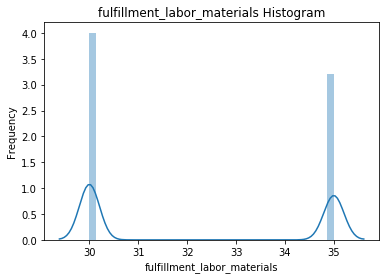

In [14]:
# Explore fulfillment_labor_materials
data_processing.make_histogram(full_df, 'fulfillment_labor_materials')

### Commentary

Based on the fact that only 30 and 35 are values for this variable, 30 and 35 appear to be some encoding. However, it is not clear what the encoding means (is that a % or $ amount that Donors Choose keeps for fulfillment, etc.?), and I was unable to find an adequate discussion online. Therefore, I will drop this column from feature selection.

In [15]:
# Define continuous and discrete variables
continuous_cols = ['total_price_excluding_optional_support',
                   'total_price_including_optional_support',]

discrete_cols = ['school_state', 'school_metro', 'outcome', 'school_charter', 
                 'school_magnet', 'school_year_round', 'school_nlns','school_kipp', 
                 'school_charter_ready_promise', 'teacher_prefix','teacher_teach_for_america', 
                 'teacher_ny_teaching_fellow','primary_focus_subject', 'primary_focus_area',
                 'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
                 'poverty_level', 'grade_level', 
                 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'month_posted']

### Continuous Columns - Total Price Including and Excludiong Optional Support

Text(0.5,1,'Total Price Including Optional Support by Year, Month')

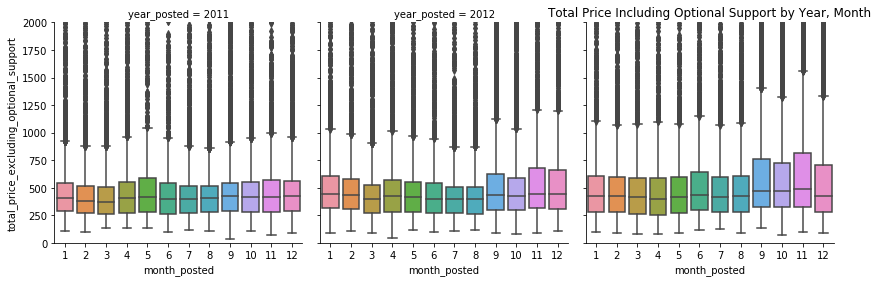

In [16]:
# Total Price Including Support
sns.factorplot(x='month_posted', y ='total_price_excluding_optional_support', col='year_posted', data=full_df, kind='box' )
plt.ylim(0,2000)
plt.title('Total Price Including Optional Support by Year, Month')

Text(0.5,1,'Total Price Excluding Optional Support by Year, Month')

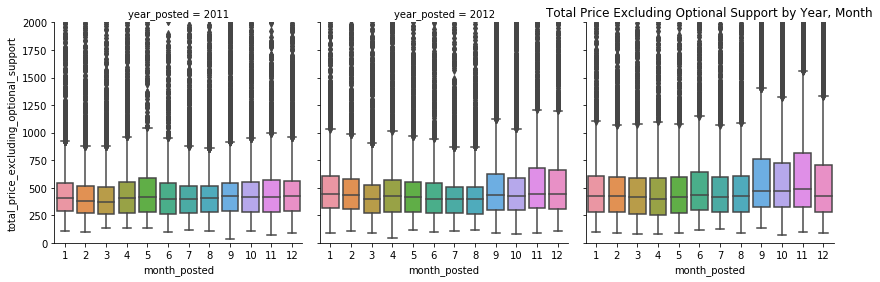

In [17]:
# Total Price Excluding Support
sns.factorplot(x='month_posted', y ='total_price_excluding_optional_support', col='year_posted', data=full_df, kind='box' )
plt.ylim(0,2000)
plt.title('Total Price Excluding Optional Support by Year, Month')

### Commentary

These are related metrics that follow similar patterns. There are a few things to notice here. Firstly, while the average project price is relatively low, around $300-$500 for almost every month in the sample period, there are a significant number of outliers are higher values. The spread of outliers also ranges up to ~$164k for the feature including optional support. In 2012 and 2013 there is a trend for large value campaigns to be posted in September through December, the first few months of the school year. We'll also see that campaign volume is also high in those months.

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


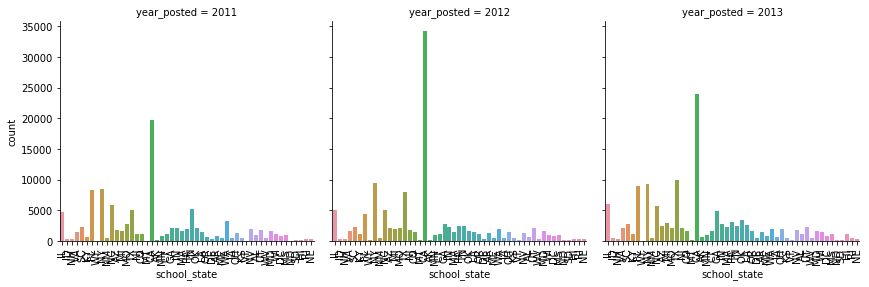

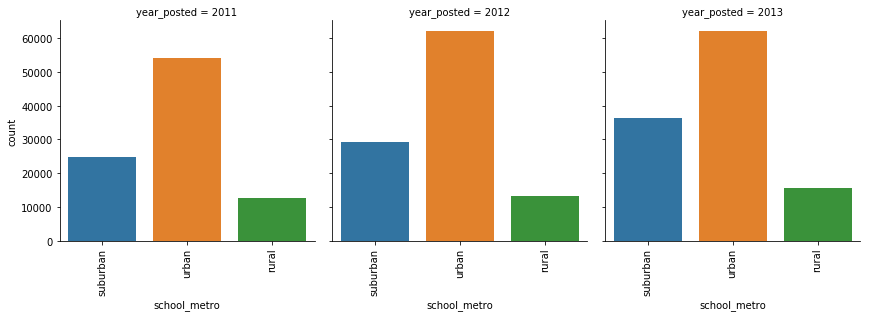

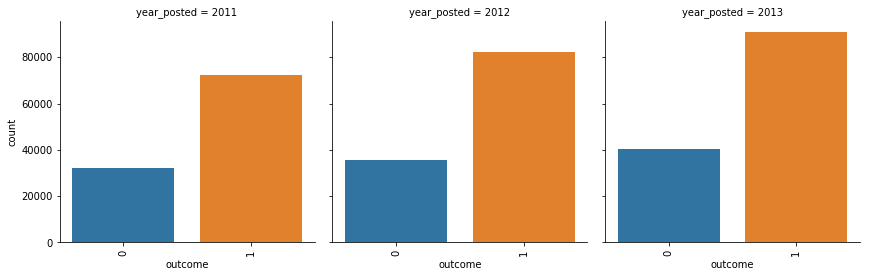

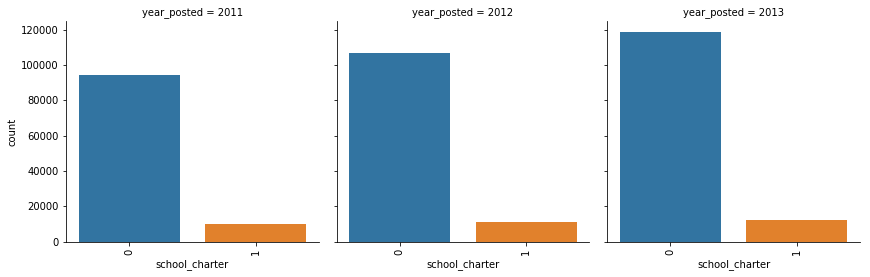

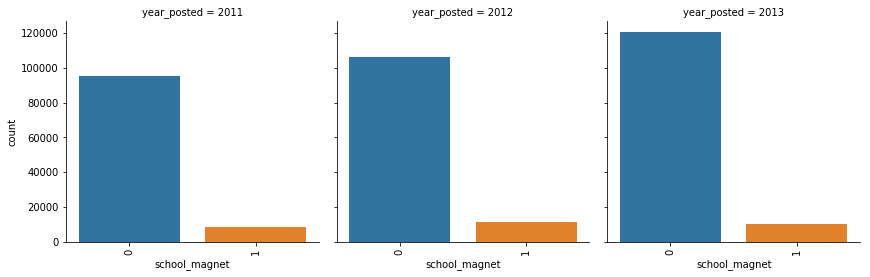

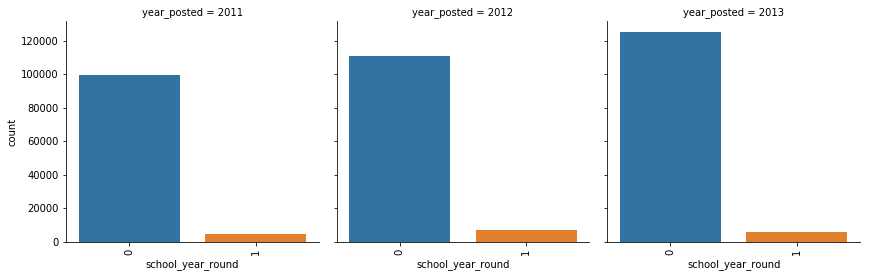

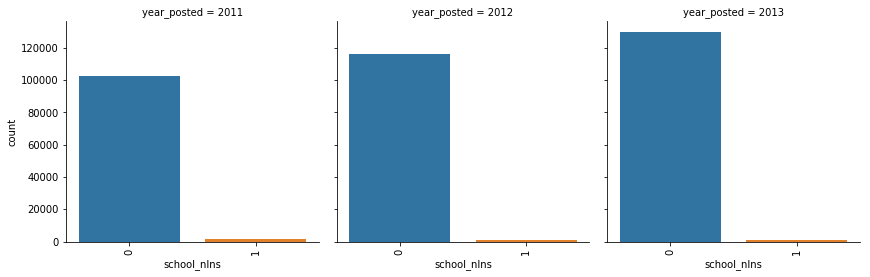

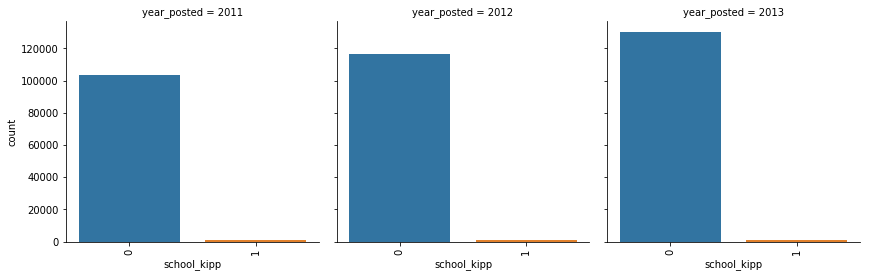

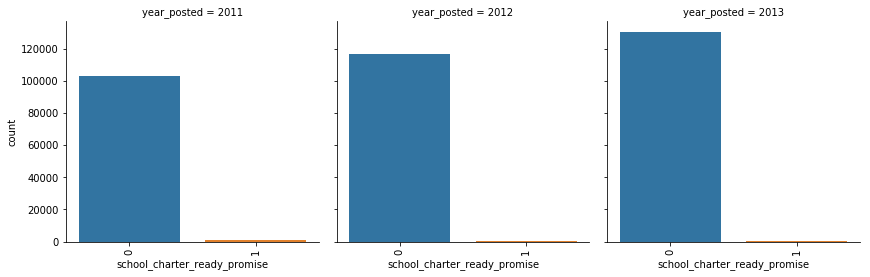

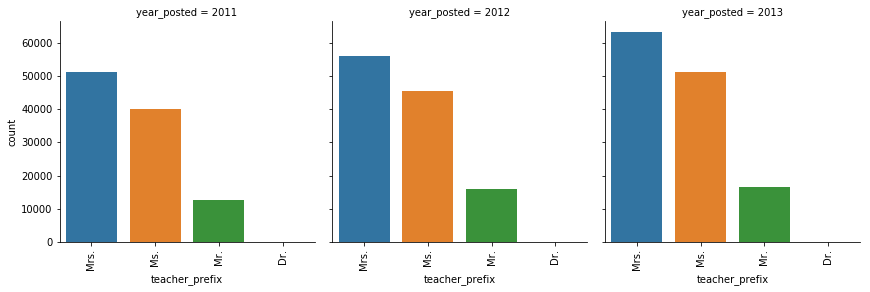

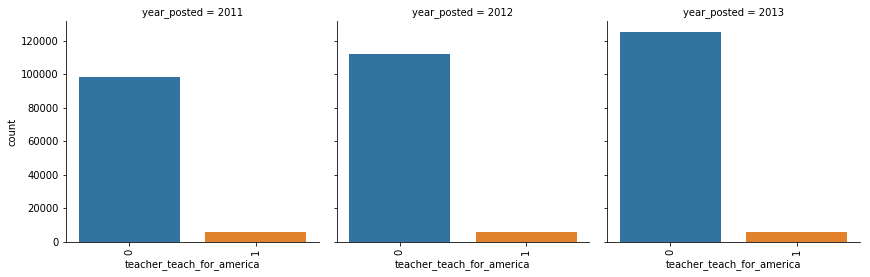

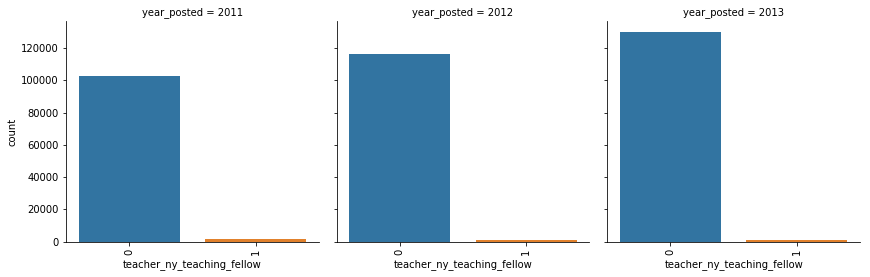

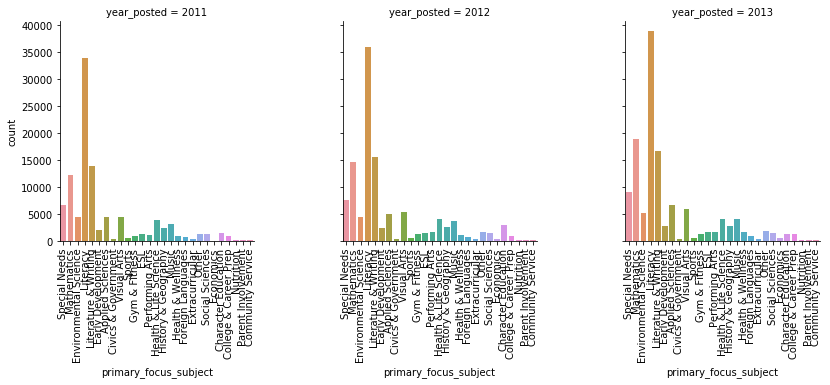

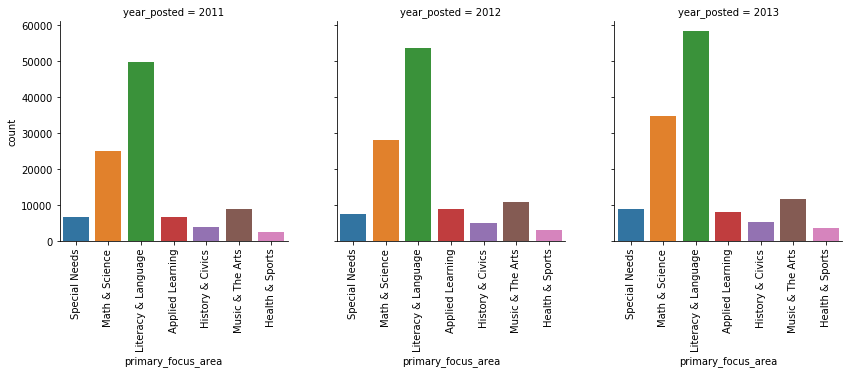

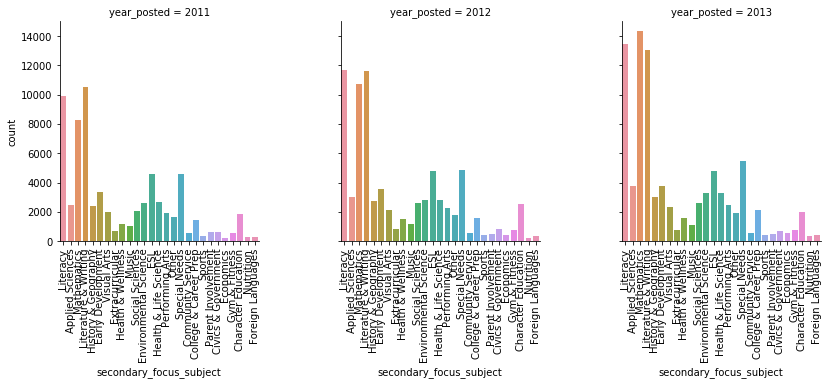

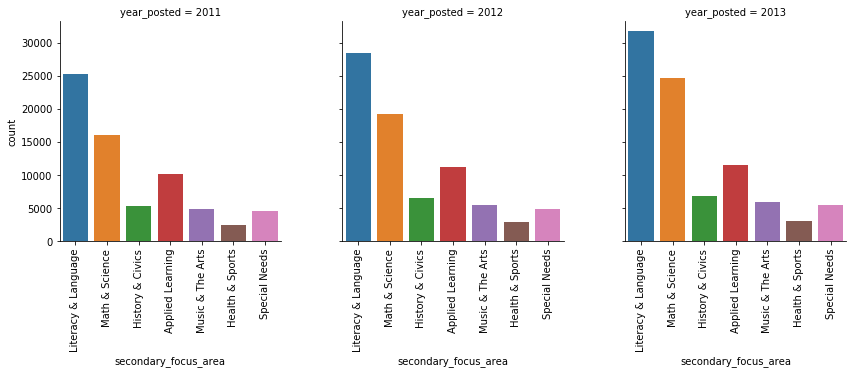

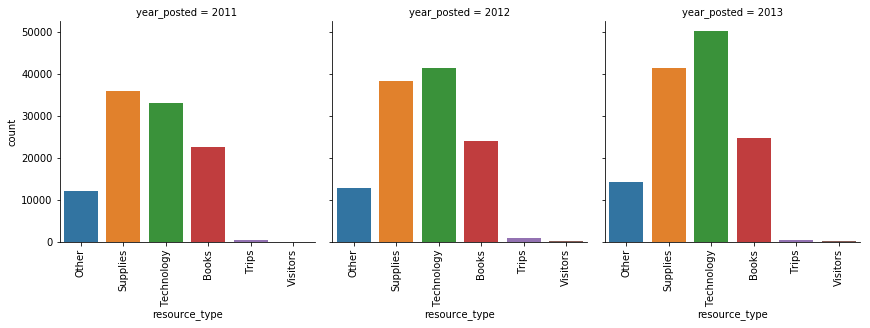

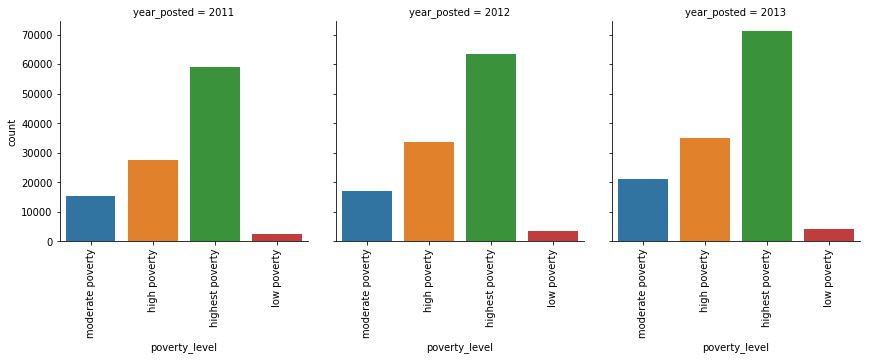

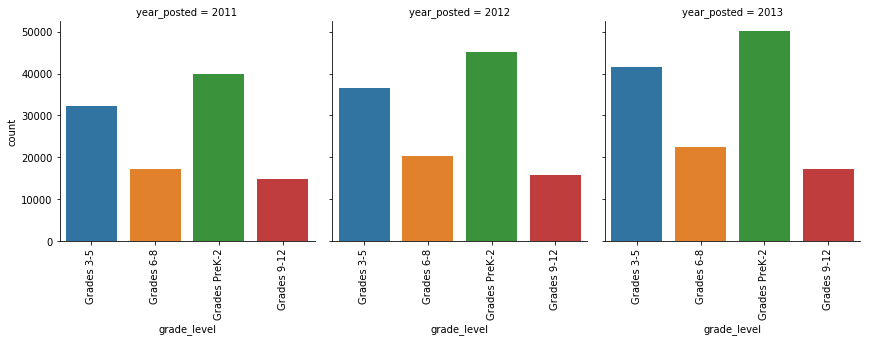

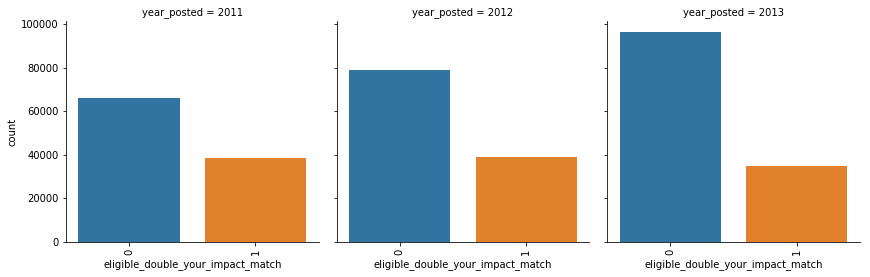

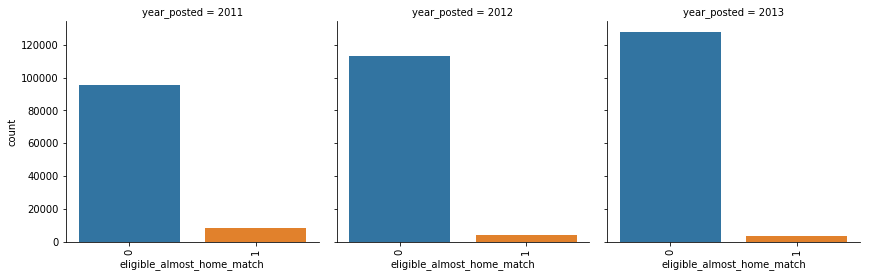

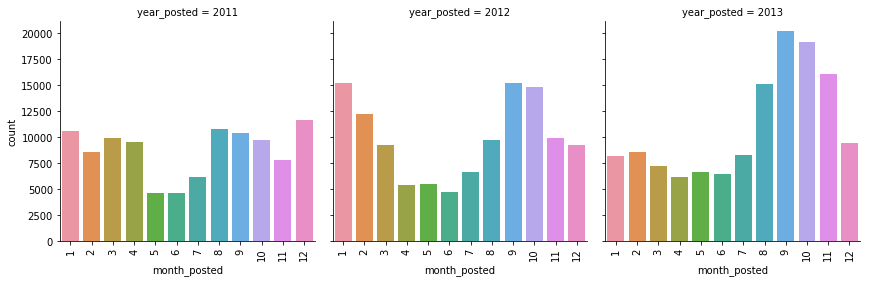

In [18]:
# Create countcharts for discrete variables
for col in discrete_cols:
    g = sns.factorplot(x=col, col = 'year_posted', data = full_df, kind = 'count')
    g.set_xticklabels(rotation=90)
    #print(data_processing.make_countchart(full_df, col))

### Commentary

There is a lot to parse out in this set of charts. One major takeaway is that the shape of the data over each year is largely similar, with total campaign volume appearing to increase year over year. A few interesting departures from this trend:
- technology
- volume in september/october

### Variable Correlation by Year

In [19]:
# Check correlation between dataset variables, 2011
corr = data_processing.check_correlations(full_df[full_df['year_posted']==2011])

Text(0.5,1,'Correlation Matrix 2011')

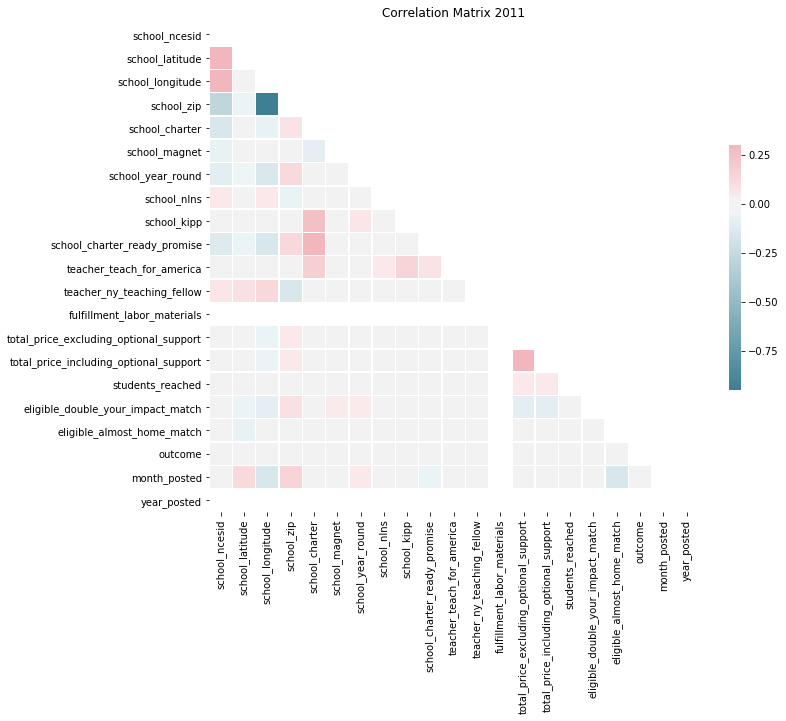

In [20]:
# Colored correlation matrix for display
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix 2011")

In [21]:
# Check correlation between dataset variables, 2012
corr = data_processing.check_correlations(full_df[full_df['year_posted']==2012])

Text(0.5,1,'Correlation Matrix 2012')

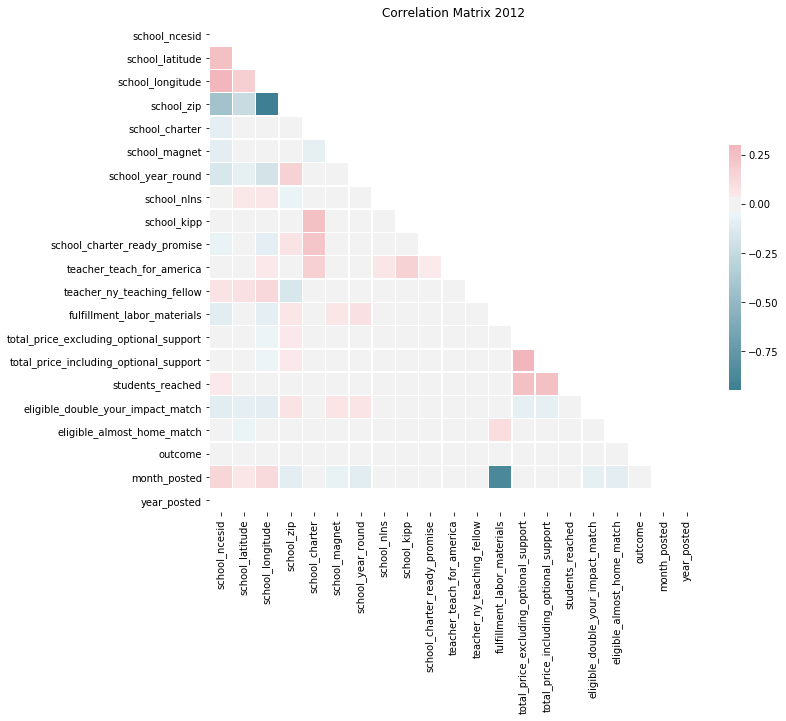

In [22]:
# Colored correlation matrix for display
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix 2012")

In [23]:
# Check correlation between dataset variables, 2013
corr = data_processing.check_correlations(full_df[full_df['year_posted']==2013])

Text(0.5,1,'Correlation Matrix 2013')

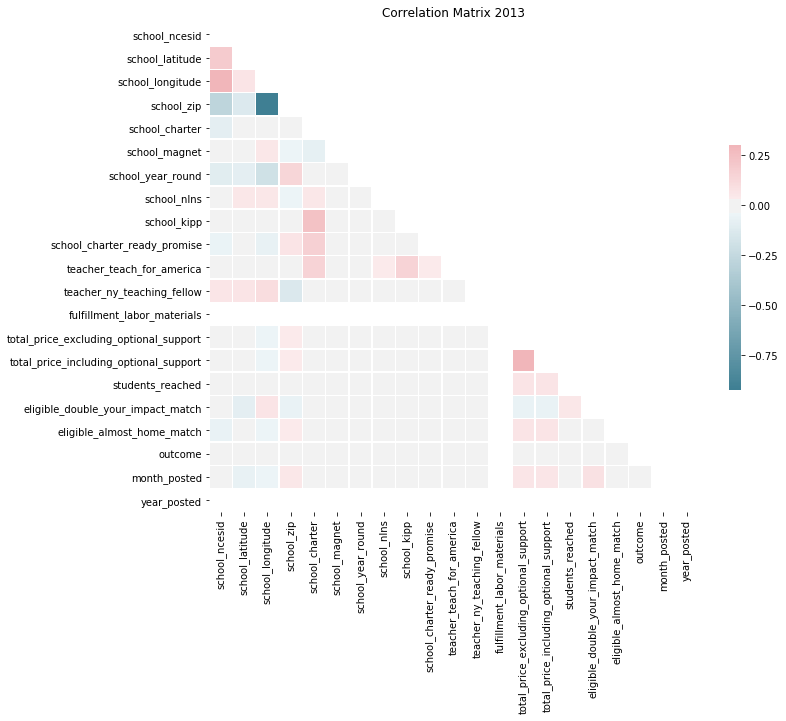

In [24]:
# Colored correlation matrix for display
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Matrix 2013")

## Commentary
Correlation between variables is generally low across the board and in all years. As might be expected, there is correlation between being a charter school and being a kipp school and/or having a teacher who is part of the Teach for America program. There is also a correlation between total prince including and excluding option support. , relationship between including and excluding optinal support.  Nothing is highly correlated with the outcome in any year.

## Additional Data Processing/Cleaning

In [25]:
# Identify columns with null values for imputation/additional processing, impute students_reached
isnull_cols = data_processing.cols_with_nulls(full_df)
isnull_cols

['school_ncesid',
 'school_metro',
 'school_district',
 'primary_focus_subject',
 'primary_focus_area',
 'secondary_focus_subject',
 'secondary_focus_area',
 'resource_type',
 'grade_level',
 'students_reached']

### Commentary
All of these variables except for Students Reached are categorical variables that will be dummified or identification fields that won't be used for analysis. Therefore I will fill only fill nulls on Students Reached. I will do that on the training and test splits individually to avoid data leakage.

## Generate Features/Predictors

In [26]:
# Categorical data to dummify
vars_to_dummify = ['school_state','school_metro', 'teacher_prefix',
                   'primary_focus_subject', 'primary_focus_area',
                   'secondary_focus_subject', 'secondary_focus_area', 
                   'resource_type','poverty_level', 'grade_level', 'month_posted', 'year_posted']

In [27]:
for var in vars_to_dummify:
    full_df = data_processing.cat_to_dummy(full_df, var)

In [28]:
# Define feature vs predictor variables
predictor = 'outcome'

max_features = [
'school_state_AK',
 'school_state_AL',
 'school_state_AR',
 'school_state_AZ',
 'school_state_CA',
 'school_state_CO',
 'school_state_CT',
 'school_state_DC',
 'school_state_DE',
 'school_state_FL',
 'school_state_GA',
 'school_state_HI',
 'school_state_IA',
 'school_state_ID',
 'school_state_IL',
 'school_state_IN',
 'school_state_KS',
 'school_state_KY',
 'school_state_LA',
 'school_state_MA',
 'school_state_MD',
 'school_state_ME',
 'school_state_MI',
 'school_state_MN',
 'school_state_MO',
 'school_state_MS',
 'school_state_MT',
 'school_state_NC',
 'school_state_ND',
 'school_state_NE',
 'school_state_NH',
 'school_state_NJ',
 'school_state_NM',
 'school_state_NV',
 'school_state_NY',
 'school_state_OH',
 'school_state_OK',
 'school_state_OR',
 'school_state_PA',
 'school_state_RI',
 'school_state_SC',
 'school_state_SD',
 'school_state_TN',
 'school_state_TX',
 'school_state_UT',
 'school_state_VA',
 'school_state_VT',
 'school_state_WA',
 'school_state_WI',
 'school_state_WV',
 'school_state_WY',
'school_charter',
'school_magnet',
'school_year_round',
'school_nlns',
'school_kipp',
'school_charter_ready_promise',
'teacher_teach_for_america',
'teacher_ny_teaching_fellow',
'total_price_excluding_optional_support',
'total_price_including_optional_support',
'students_reached',
'eligible_double_your_impact_match',
'eligible_almost_home_match',
'school_metro_rural',
'school_metro_suburban',
'school_metro_urban',
'teacher_prefix_Dr.',
'teacher_prefix_Mr.',
'teacher_prefix_Mrs.',
'teacher_prefix_Ms.',
'primary_focus_subject_Applied Sciences',
'primary_focus_subject_Character Education',
'primary_focus_subject_Civics & Government',
'primary_focus_subject_College & Career Prep',
'primary_focus_subject_Community Service',
'primary_focus_subject_ESL',
'primary_focus_subject_Early Development',
'primary_focus_subject_Economics',
'primary_focus_subject_Environmental Science',
'primary_focus_subject_Extracurricular',
'primary_focus_subject_Foreign Languages',
'primary_focus_subject_Gym & Fitness',
'primary_focus_subject_Health & Life Science',
'primary_focus_subject_Health & Wellness',
'primary_focus_subject_History & Geography',
'primary_focus_subject_Literacy',
'primary_focus_subject_Literature & Writing',
'primary_focus_subject_Mathematics',
'primary_focus_subject_Music',
'primary_focus_subject_Nutrition',
'primary_focus_subject_Other',
'primary_focus_subject_Parent Involvement',
'primary_focus_subject_Performing Arts',
'primary_focus_subject_Social Sciences',
'primary_focus_subject_Special Needs',
'primary_focus_subject_Sports',
'primary_focus_subject_Visual Arts',
'primary_focus_area_Applied Learning',
'primary_focus_area_Health & Sports',
'primary_focus_area_History & Civics',
'primary_focus_area_Literacy & Language',
'primary_focus_area_Math & Science',
'primary_focus_area_Music & The Arts',
'primary_focus_area_Special Needs',
'secondary_focus_subject_Applied Sciences',
'secondary_focus_subject_Character Education',
'secondary_focus_subject_Civics & Government',
'secondary_focus_subject_College & Career Prep',
'secondary_focus_subject_Community Service',
'secondary_focus_subject_ESL',
'secondary_focus_subject_Early Development',
'secondary_focus_subject_Economics',
'secondary_focus_subject_Environmental Science',
'secondary_focus_subject_Extracurricular',
'secondary_focus_subject_Foreign Languages',
'secondary_focus_subject_Gym & Fitness',
'secondary_focus_subject_Health & Life Science',
'secondary_focus_subject_Health & Wellness',
'secondary_focus_subject_History & Geography',
'secondary_focus_subject_Literacy',
'secondary_focus_subject_Literature & Writing',
'secondary_focus_subject_Mathematics',
'secondary_focus_subject_Music',
'secondary_focus_subject_Nutrition',
'secondary_focus_subject_Other',
'secondary_focus_subject_Parent Involvement',
'secondary_focus_subject_Performing Arts',
'secondary_focus_subject_Social Sciences',
'secondary_focus_subject_Special Needs',
'secondary_focus_subject_Sports',
'secondary_focus_subject_Visual Arts',
'secondary_focus_area_Applied Learning',
'secondary_focus_area_Health & Sports',
'secondary_focus_area_History & Civics',
'secondary_focus_area_Literacy & Language',
'secondary_focus_area_Math & Science',
'secondary_focus_area_Music & The Arts',
'secondary_focus_area_Special Needs',
'resource_type_Books',
'resource_type_Other',
'resource_type_Supplies',
'resource_type_Technology',
'resource_type_Trips',
'resource_type_Visitors',
'poverty_level_high poverty',
'poverty_level_highest poverty',
'poverty_level_low poverty',
'poverty_level_moderate poverty',
'grade_level_Grades 3-5',
'grade_level_Grades 6-8',
'grade_level_Grades 9-12',
'grade_level_Grades PreK-2',
'month_posted_1',
'month_posted_2',
'month_posted_3',
'month_posted_4',
'month_posted_5',
'month_posted_6',
'month_posted_7',
'month_posted_8',
'month_posted_9',
'month_posted_10',
'month_posted_11',
'month_posted_12',
'year_posted_2011',
'year_posted_2012',
'year_posted_2013'   
]

In [29]:
# for reference
all_cols = [
'projectid_x',
'teacher_acctid',
'schoolid',
'school_ncesid',
'school_latitude',
'school_longitude',
'school_city',
'school_state_AK',
 'school_state_AL',
 'school_state_AR',
 'school_state_AZ',
 'school_state_CA',
 'school_state_CO',
 'school_state_CT',
 'school_state_DC',
 'school_state_DE',
 'school_state_FL',
 'school_state_GA',
 'school_state_HI',
 'school_state_IA',
 'school_state_ID',
 'school_state_IL',
 'school_state_IN',
 'school_state_KS',
 'school_state_KY',
 'school_state_LA',
 'school_state_MA',
 'school_state_MD',
 'school_state_ME',
 'school_state_MI',
 'school_state_MN',
 'school_state_MO',
 'school_state_MS',
 'school_state_MT',
 'school_state_NC',
 'school_state_ND',
 'school_state_NE',
 'school_state_NH',
 'school_state_NJ',
 'school_state_NM',
 'school_state_NV',
 'school_state_NY',
 'school_state_OH',
 'school_state_OK',
 'school_state_OR',
 'school_state_PA',
 'school_state_RI',
 'school_state_SC',
 'school_state_SD',
 'school_state_TN',
 'school_state_TX',
 'school_state_UT',
 'school_state_VA',
 'school_state_VT',
 'school_state_WA',
 'school_state_WI',
 'school_state_WV',
 'school_state_WY',
'school_zip',
'school_district',
'school_county',
'school_charter',
'school_magnet',
'school_year_round',
'school_nlns',
'school_kipp',
'school_charter_ready_promise',
'teacher_teach_for_america',
'teacher_ny_teaching_fellow',
'fulfillment_labor_materials',
'total_price_excluding_optional_support',
'total_price_including_optional_support',
'students_reached',
'eligible_double_your_impact_match',
'eligible_almost_home_match',
'date_posted',
'outcome',
'school_metro_rural',
'school_metro_suburban',
'school_metro_urban',
'teacher_prefix_Dr.',
'teacher_prefix_Mr.',
'teacher_prefix_Mrs.',
'teacher_prefix_Ms.',
'primary_focus_subject_Applied Sciences',
'primary_focus_subject_Character Education',
'primary_focus_subject_Civics & Government',
'primary_focus_subject_College & Career Prep',
'primary_focus_subject_Community Service',
'primary_focus_subject_ESL',
'primary_focus_subject_Early Development',
'primary_focus_subject_Economics',
'primary_focus_subject_Environmental Science',
'primary_focus_subject_Extracurricular',
'primary_focus_subject_Foreign Languages',
'primary_focus_subject_Gym & Fitness',
'primary_focus_subject_Health & Life Science',
'primary_focus_subject_Health & Wellness',
'primary_focus_subject_History & Geography',
'primary_focus_subject_Literacy',
'primary_focus_subject_Literature & Writing',
'primary_focus_subject_Mathematics',
'primary_focus_subject_Music',
'primary_focus_subject_Nutrition',
'primary_focus_subject_Other',
'primary_focus_subject_Parent Involvement',
'primary_focus_subject_Performing Arts',
'primary_focus_subject_Social Sciences',
'primary_focus_subject_Special Needs',
'primary_focus_subject_Sports',
'primary_focus_subject_Visual Arts',
'primary_focus_area_Applied Learning',
'primary_focus_area_Health & Sports',
'primary_focus_area_History & Civics',
'primary_focus_area_Literacy & Language',
'primary_focus_area_Math & Science',
'primary_focus_area_Music & The Arts',
'primary_focus_area_Special Needs',
'secondary_focus_subject_Applied Sciences',
'secondary_focus_subject_Character Education',
'secondary_focus_subject_Civics & Government',
'secondary_focus_subject_College & Career Prep',
'secondary_focus_subject_Community Service',
'secondary_focus_subject_ESL',
'secondary_focus_subject_Early Development',
'secondary_focus_subject_Economics',
'secondary_focus_subject_Environmental Science',
'secondary_focus_subject_Extracurricular',
'secondary_focus_subject_Foreign Languages',
'secondary_focus_subject_Gym & Fitness',
'secondary_focus_subject_Health & Life Science',
'secondary_focus_subject_Health & Wellness',
'secondary_focus_subject_History & Geography',
'secondary_focus_subject_Literacy',
'secondary_focus_subject_Literature & Writing',
'secondary_focus_subject_Mathematics',
'secondary_focus_subject_Music',
'secondary_focus_subject_Nutrition',
'secondary_focus_subject_Other',
'secondary_focus_subject_Parent Involvement',
'secondary_focus_subject_Performing Arts',
'secondary_focus_subject_Social Sciences',
'secondary_focus_subject_Special Needs',
'secondary_focus_subject_Sports',
'secondary_focus_subject_Visual Arts',
'secondary_focus_area_Applied Learning',
'secondary_focus_area_Health & Sports',
'secondary_focus_area_History & Civics',
'secondary_focus_area_Literacy & Language',
'secondary_focus_area_Math & Science',
'secondary_focus_area_Music & The Arts',
'secondary_focus_area_Special Needs',
'resource_type_Books',
'resource_type_Other',
'resource_type_Supplies',
'resource_type_Technology',
'resource_type_Trips',
'resource_type_Visitors',
'poverty_level_high poverty',
'poverty_level_highest poverty',
'poverty_level_low poverty',
'poverty_level_moderate poverty',
'grade_level_Grades 3-5',
'grade_level_Grades 6-8',
'grade_level_Grades 9-12',
'grade_level_Grades PreK-2',
'month_posted_1',
'month_posted_2',
'month_posted_3',
'month_posted_4',
'month_posted_5',
'month_posted_6',
'month_posted_7',
'month_posted_8',
'month_posted_9',
'month_posted_10',
'month_posted_11',
'month_posted_12',
'year_posted_2011',
'year_posted_2012',
'year_posted_2013'
]

In [30]:
[x for x in full_df.columns if 'state' in x]

['school_state_AK',
 'school_state_AL',
 'school_state_AR',
 'school_state_AZ',
 'school_state_CA',
 'school_state_CO',
 'school_state_CT',
 'school_state_DC',
 'school_state_DE',
 'school_state_FL',
 'school_state_GA',
 'school_state_HI',
 'school_state_IA',
 'school_state_ID',
 'school_state_IL',
 'school_state_IN',
 'school_state_KS',
 'school_state_KY',
 'school_state_LA',
 'school_state_MA',
 'school_state_MD',
 'school_state_ME',
 'school_state_MI',
 'school_state_MN',
 'school_state_MO',
 'school_state_MS',
 'school_state_MT',
 'school_state_NC',
 'school_state_ND',
 'school_state_NE',
 'school_state_NH',
 'school_state_NJ',
 'school_state_NM',
 'school_state_NV',
 'school_state_NY',
 'school_state_OH',
 'school_state_OK',
 'school_state_OR',
 'school_state_PA',
 'school_state_RI',
 'school_state_SC',
 'school_state_SD',
 'school_state_TN',
 'school_state_TX',
 'school_state_UT',
 'school_state_VA',
 'school_state_VT',
 'school_state_WA',
 'school_state_WI',
 'school_state_WV',


## Modeling and Evaluation
Note: This temporal validation and looping code is modeled after those found here in Rayid's repo:
https://github.com/rayidghani/magicloops

In [31]:
# Determine start and end date
start_time_date = full_df['date_posted'].min()
end_time_date = full_df['date_posted'].max()

# how far out do we want to predict in months and how do we increment our training period
# i.e. first we train the first 6 months test next 6, then train 12 months test 6, then train 18 months test 6, etc.
prediction_windows = [6, 12]

In [32]:
models_to_run=['RF', 'BG', 'AB', 'LR', 'GB', 'DT', 'KNN'] #'SVM', 
# Note: SVM takes prohibitively long to run, so I am excluding for the purpose of producing results in a reasonable
# timeframe. See below for paramaters that would be tested

clfs = {
    'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'BG': BaggingClassifier(LogisticRegression(penalty='l1', C=1)),
    'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
    'LR': LogisticRegression(penalty='l1', C=15),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=3) 
        }

grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    # no bootstrap, bootstrap_features for time to train constraints
    'BG':{'n_estimators': [10, 10], 'max_samples': [0.1, 0.5], 'max_features':[0.1, 0.5]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.001,0.01, 0.1,1,10]},
    'SVM' :{'C' :[0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    # Same as test row for time to run considerations
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20],'min_samples_split': [2,5,10]},
    'KNN' :{'n_neighbors': [5,10,25],'weights': ['uniform','distance'],'algorithm': ['auto','kd_tree']}
           }
    
test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'BG':{'n_estimators': [1], 'max_samples': [0.5], 'max_features':[0.5], 'bootstrap': [False], 'bootstrap_features':[False]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }

training date range: 2011-01-01 00:00:00 2011-06-30 00:00:00
testing date range: 2011-07-01 00:00:00 2011-12-31 00:00:00
RF


<Figure size 432x288 with 0 Axes>

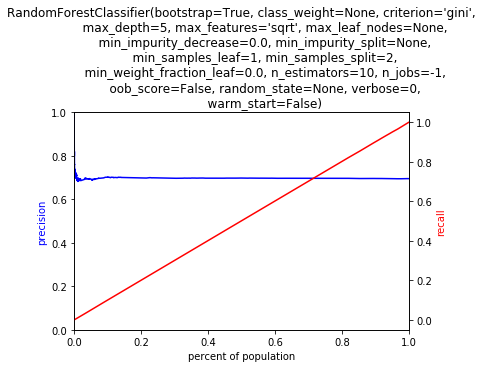

<Figure size 432x288 with 0 Axes>

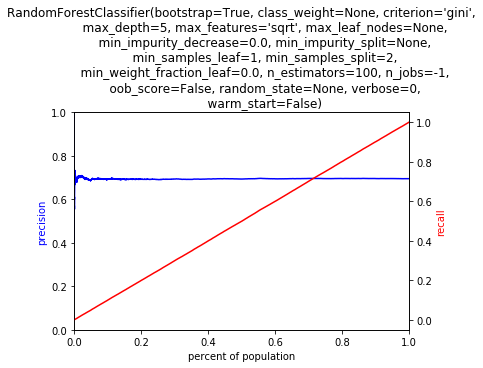

<Figure size 432x288 with 0 Axes>

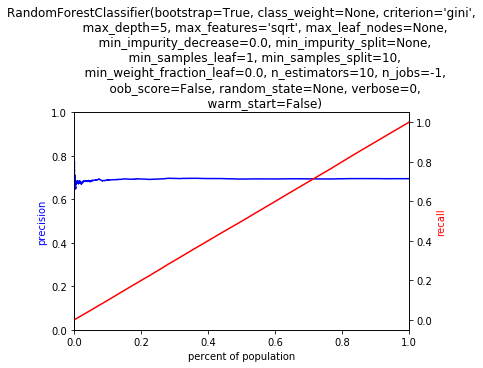

<Figure size 432x288 with 0 Axes>

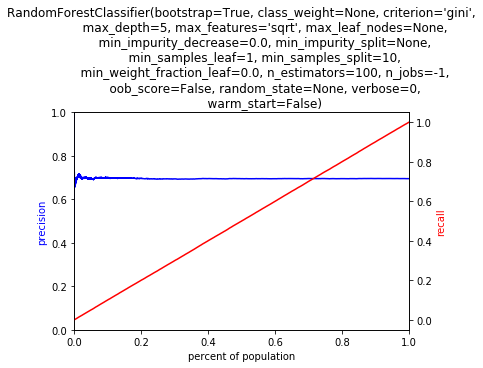

<Figure size 432x288 with 0 Axes>

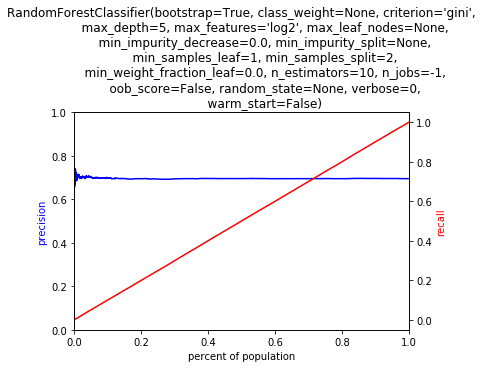

<Figure size 432x288 with 0 Axes>

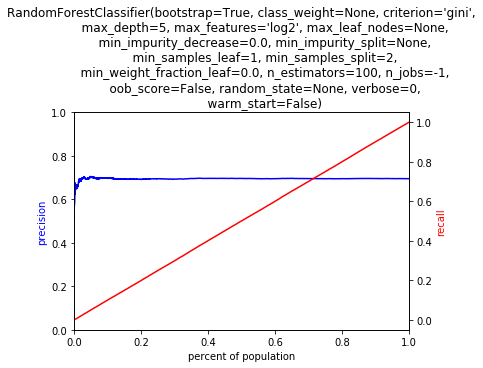

<Figure size 432x288 with 0 Axes>

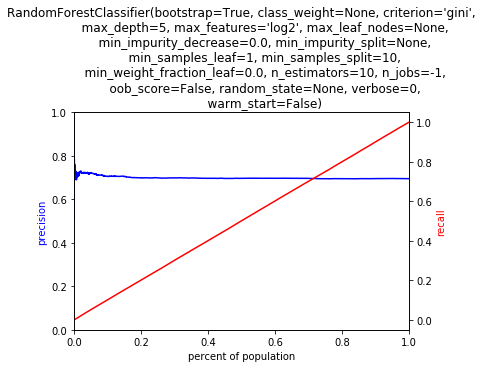

<Figure size 432x288 with 0 Axes>

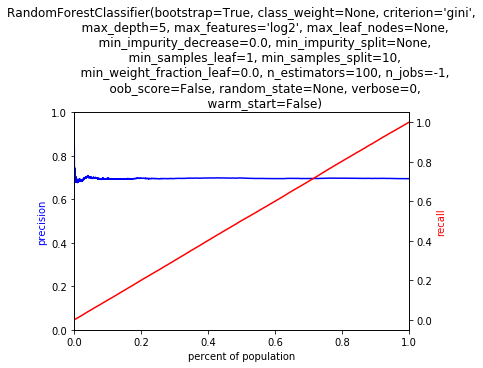

<Figure size 432x288 with 0 Axes>

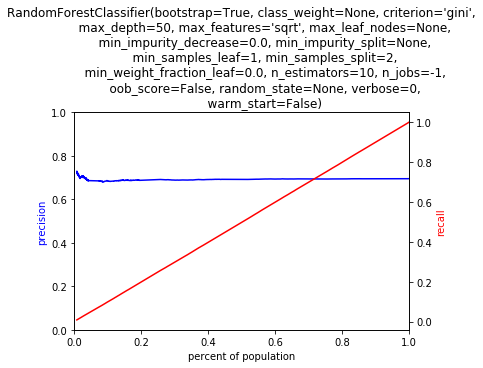

<Figure size 432x288 with 0 Axes>

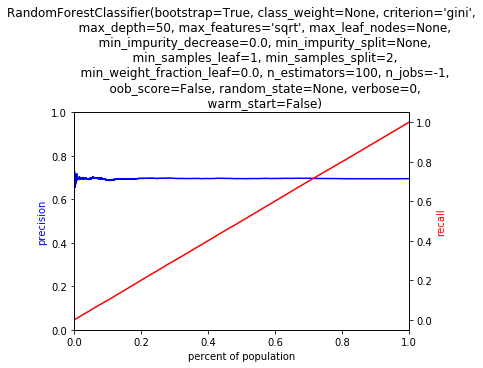

<Figure size 432x288 with 0 Axes>

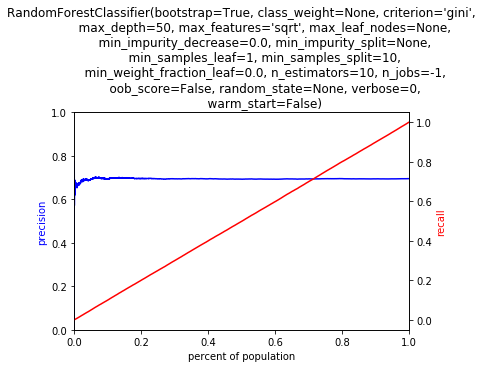

<Figure size 432x288 with 0 Axes>

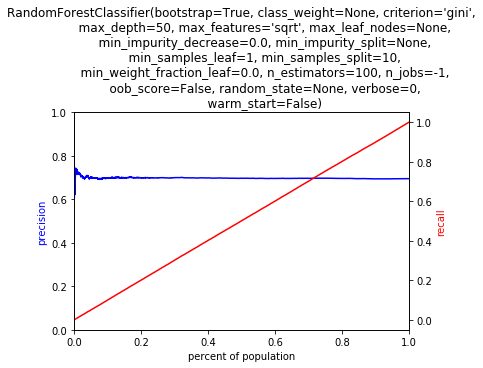

<Figure size 432x288 with 0 Axes>

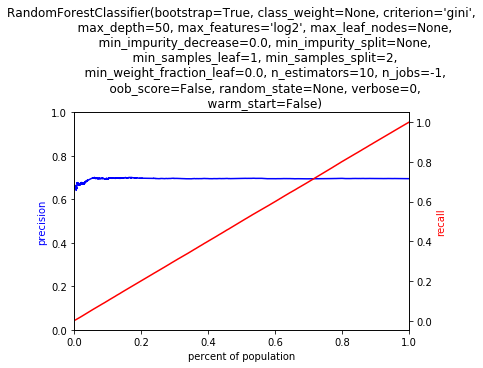

<Figure size 432x288 with 0 Axes>

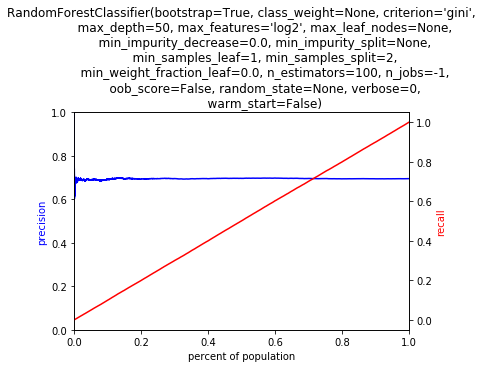

<Figure size 432x288 with 0 Axes>

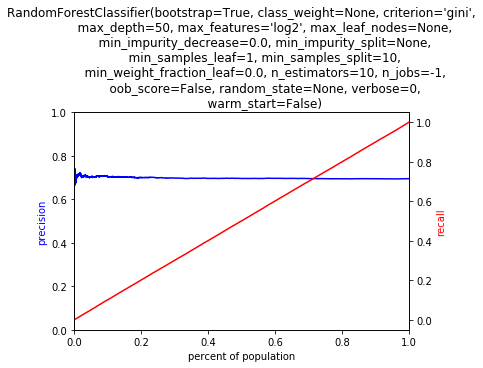

<Figure size 432x288 with 0 Axes>

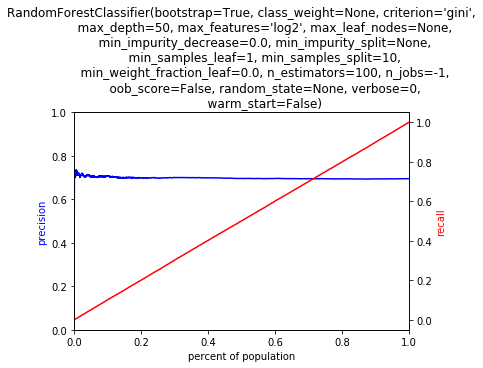

BG


<Figure size 432x288 with 0 Axes>

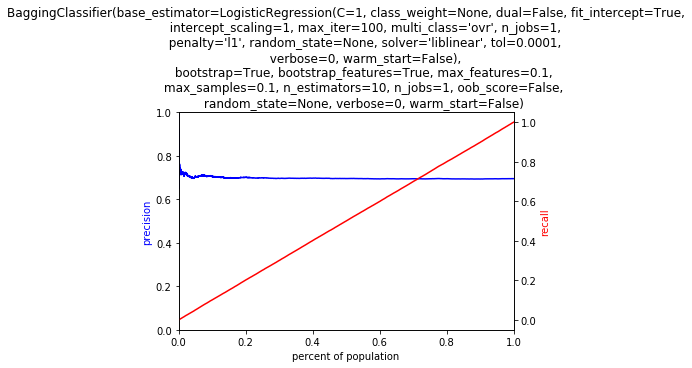

<Figure size 432x288 with 0 Axes>

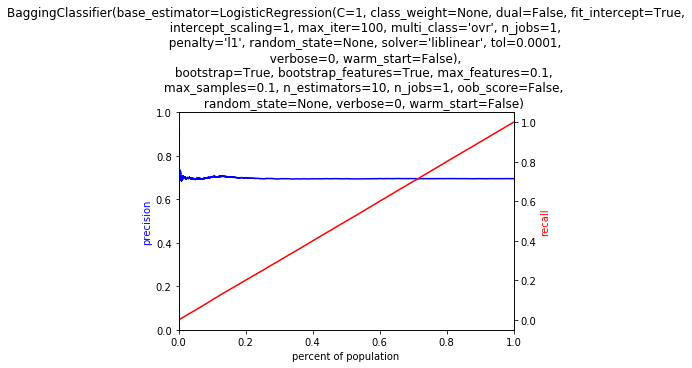

<Figure size 432x288 with 0 Axes>

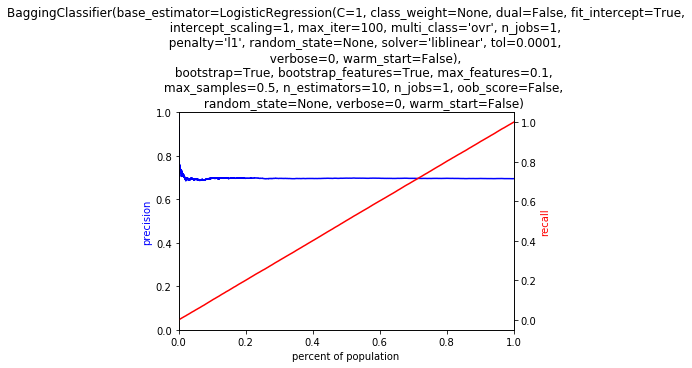

<Figure size 432x288 with 0 Axes>

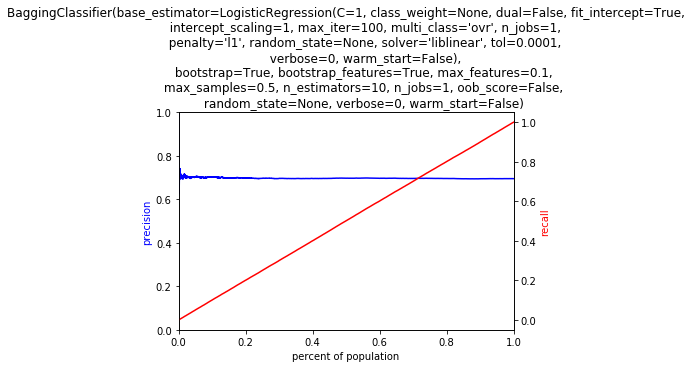

<Figure size 432x288 with 0 Axes>

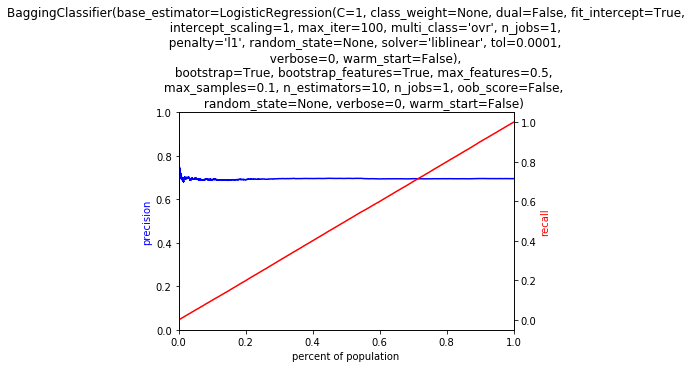

<Figure size 432x288 with 0 Axes>

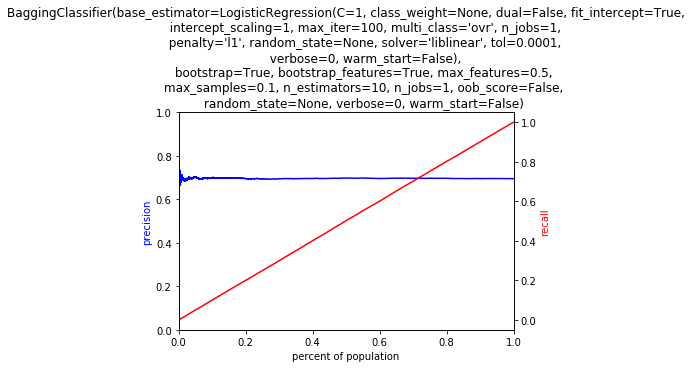

<Figure size 432x288 with 0 Axes>

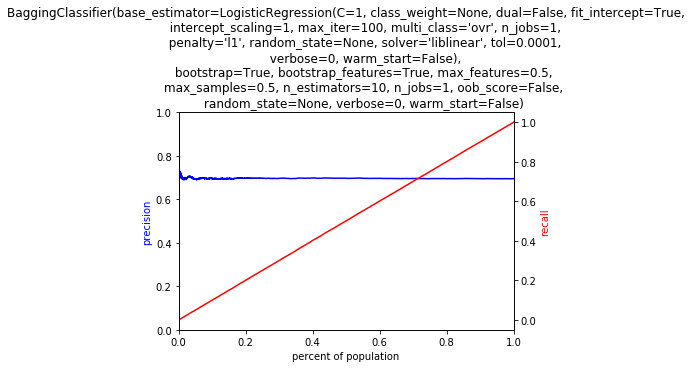

<Figure size 432x288 with 0 Axes>

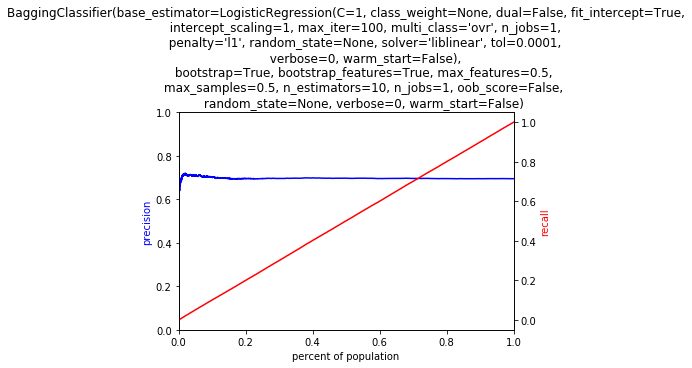

<Figure size 432x288 with 0 Axes>

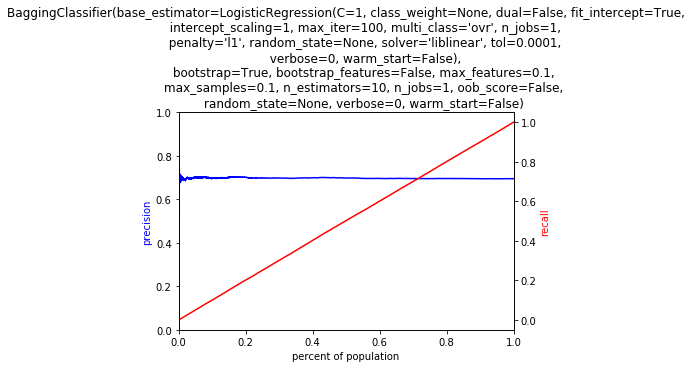

<Figure size 432x288 with 0 Axes>

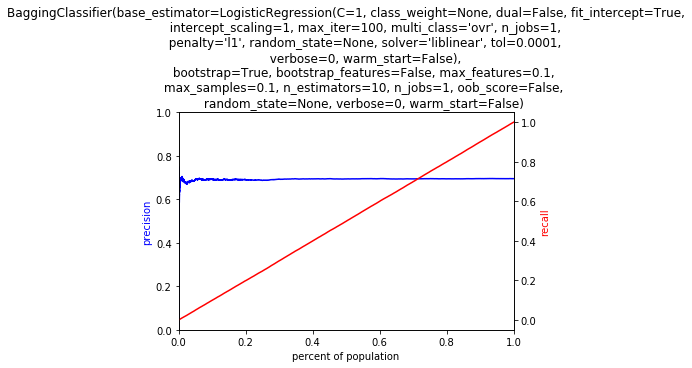

<Figure size 432x288 with 0 Axes>

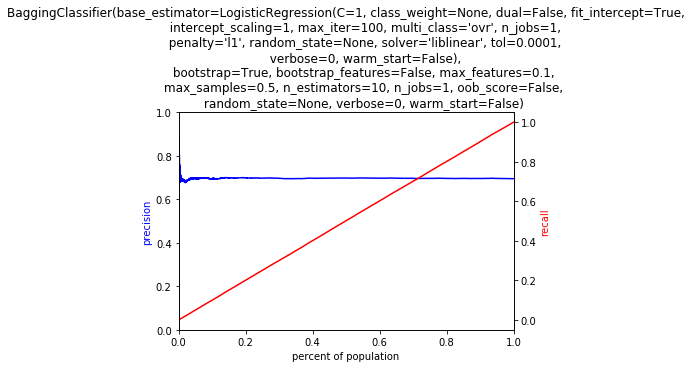

<Figure size 432x288 with 0 Axes>

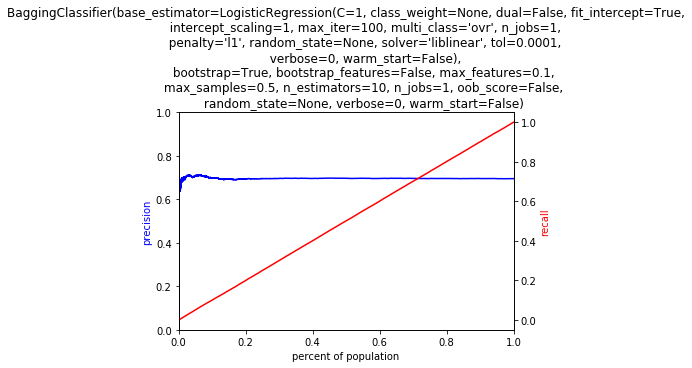

<Figure size 432x288 with 0 Axes>

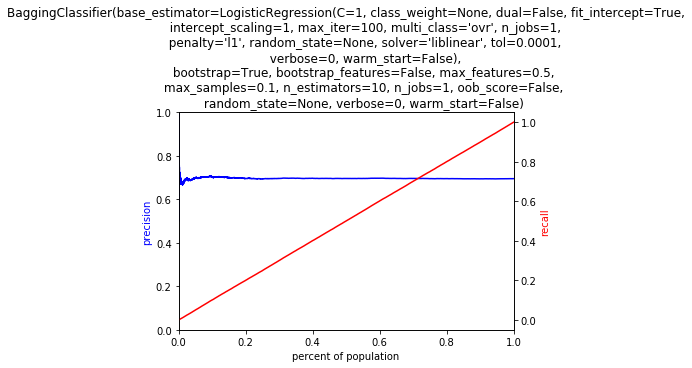

<Figure size 432x288 with 0 Axes>

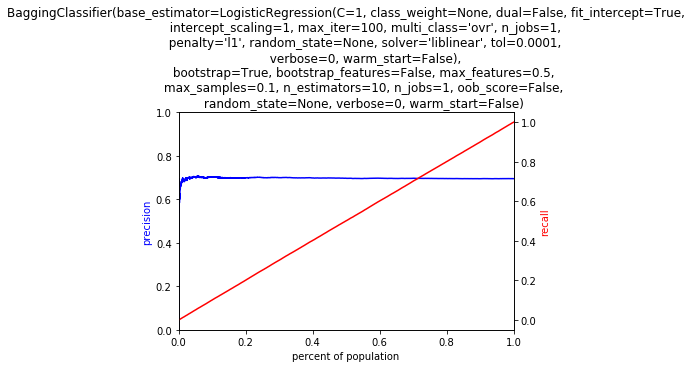

<Figure size 432x288 with 0 Axes>

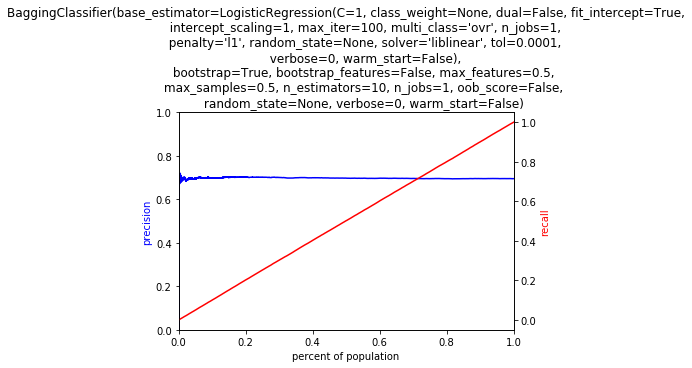

<Figure size 432x288 with 0 Axes>

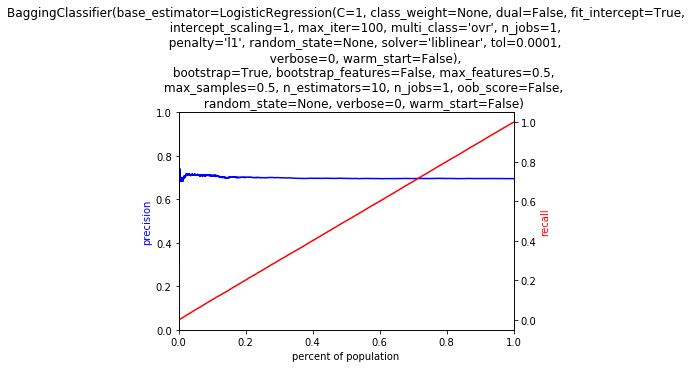

<Figure size 432x288 with 0 Axes>

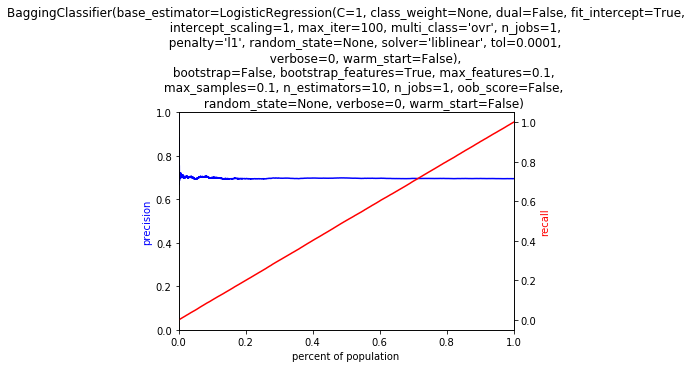

<Figure size 432x288 with 0 Axes>

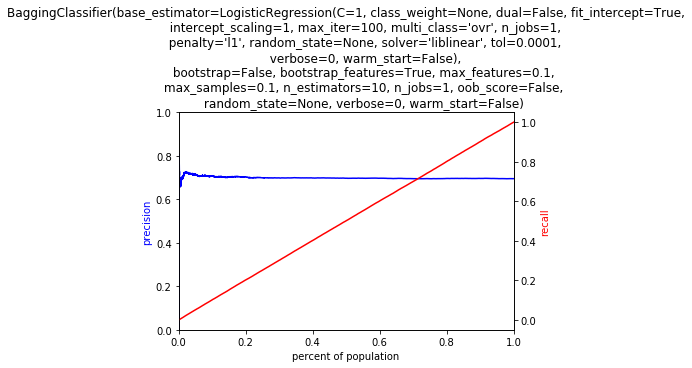

<Figure size 432x288 with 0 Axes>

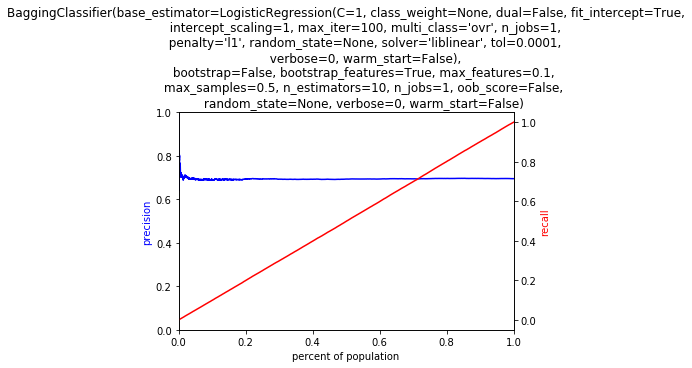

<Figure size 432x288 with 0 Axes>

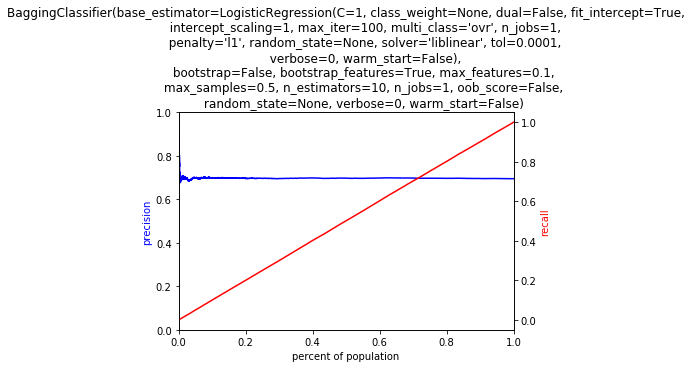

<Figure size 432x288 with 0 Axes>

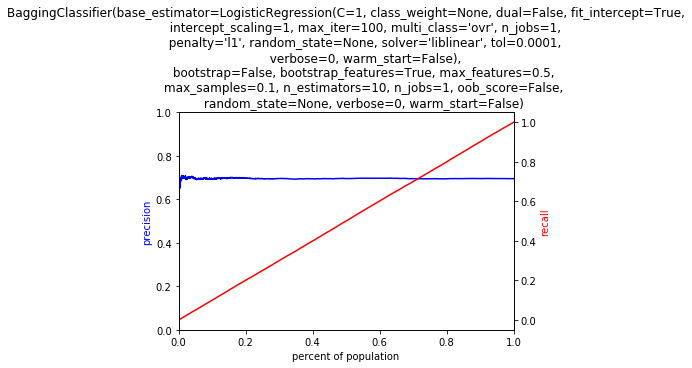

<Figure size 432x288 with 0 Axes>

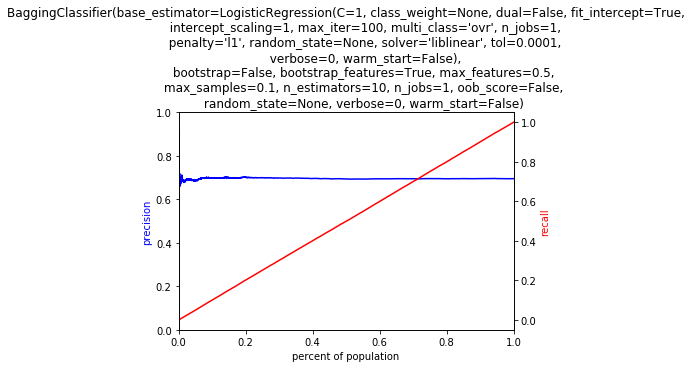

<Figure size 432x288 with 0 Axes>

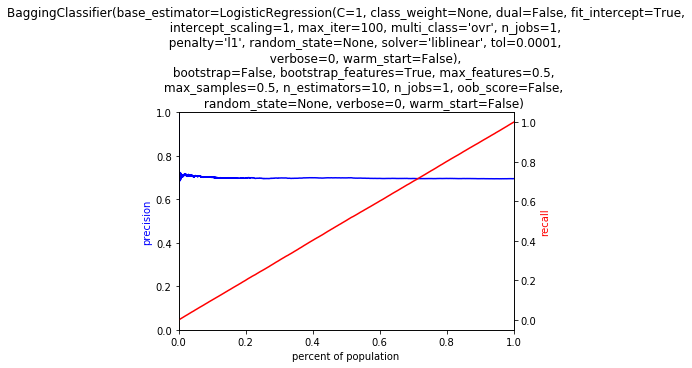

<Figure size 432x288 with 0 Axes>

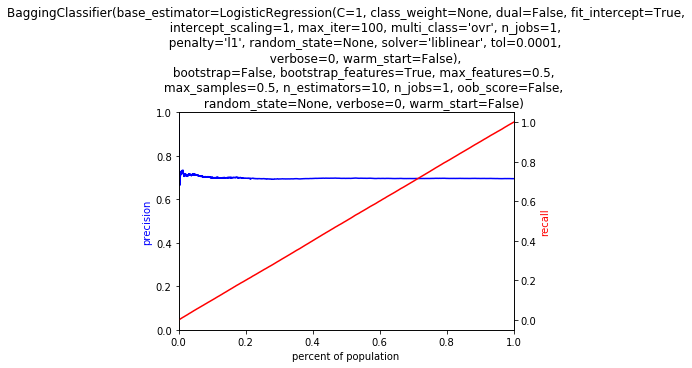

<Figure size 432x288 with 0 Axes>

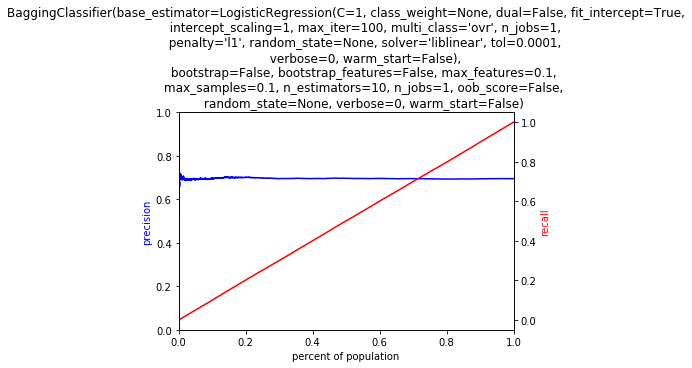

<Figure size 432x288 with 0 Axes>

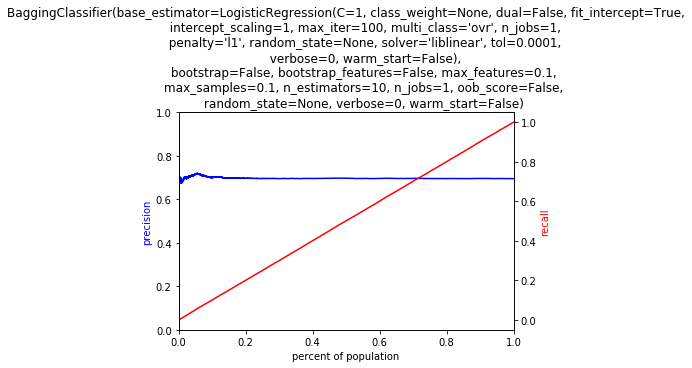

<Figure size 432x288 with 0 Axes>

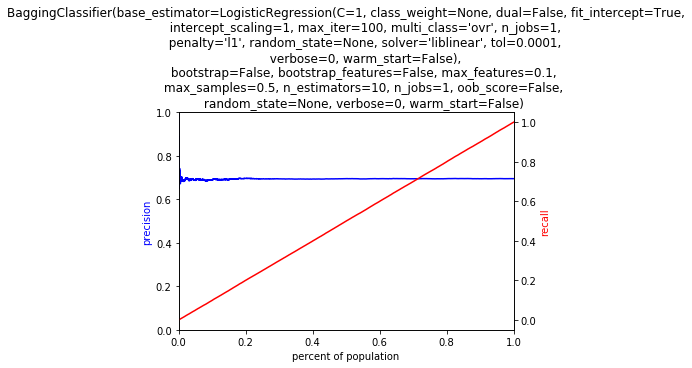

<Figure size 432x288 with 0 Axes>

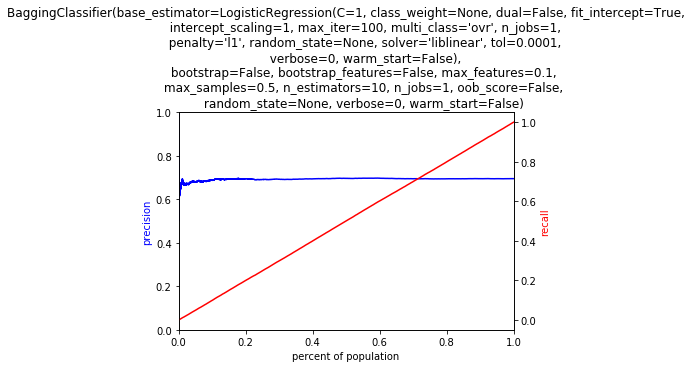

<Figure size 432x288 with 0 Axes>

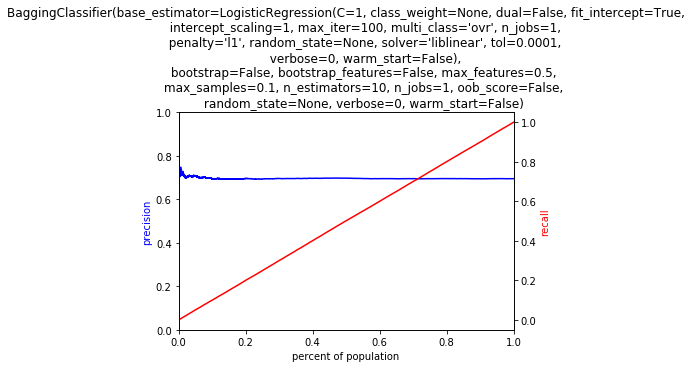

<Figure size 432x288 with 0 Axes>

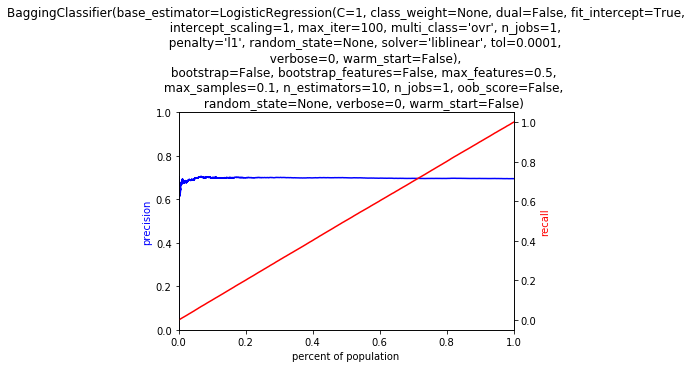

<Figure size 432x288 with 0 Axes>

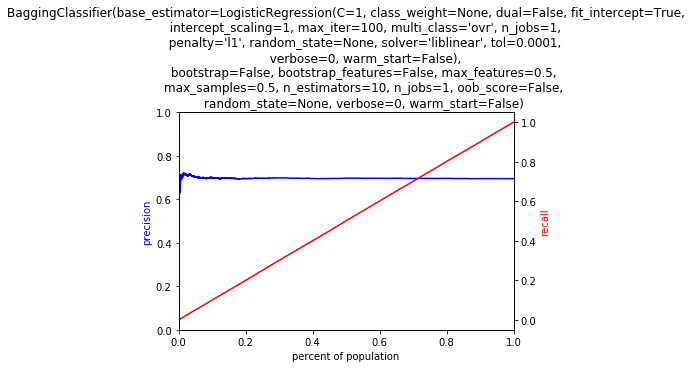

<Figure size 432x288 with 0 Axes>

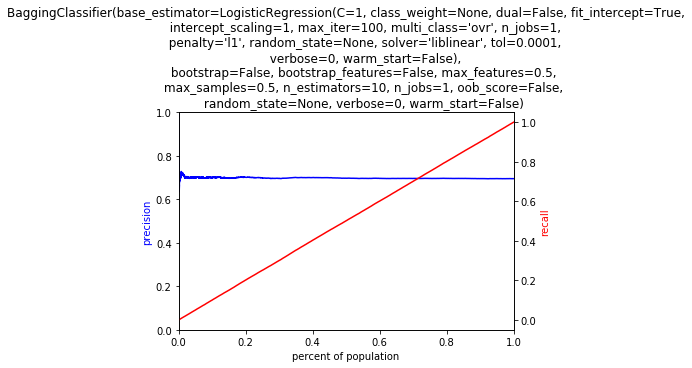

AB


<Figure size 432x288 with 0 Axes>

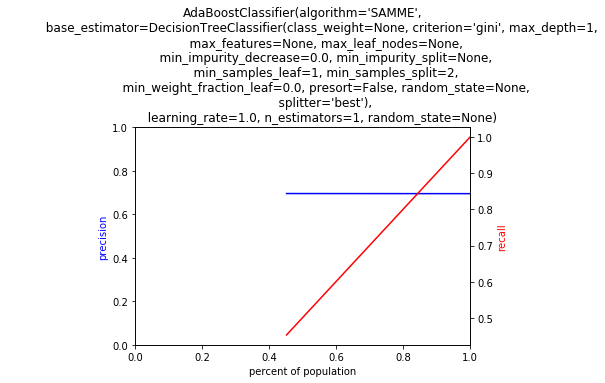

<Figure size 432x288 with 0 Axes>

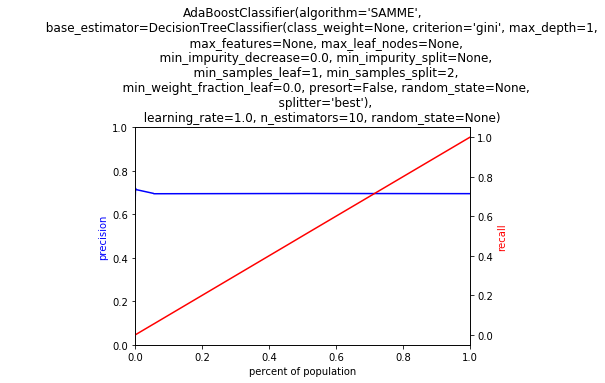

<Figure size 432x288 with 0 Axes>

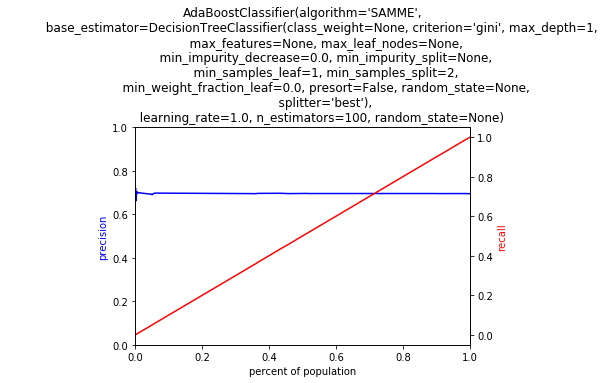

<Figure size 432x288 with 0 Axes>

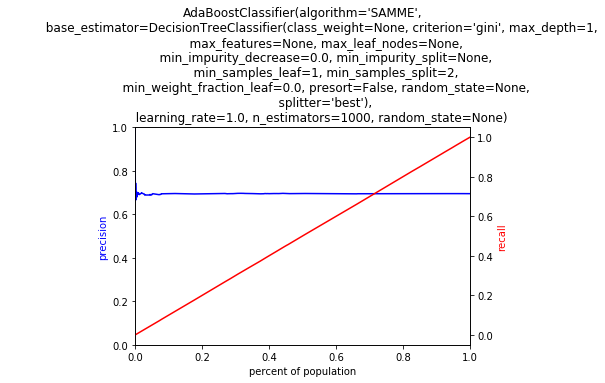

<Figure size 432x288 with 0 Axes>

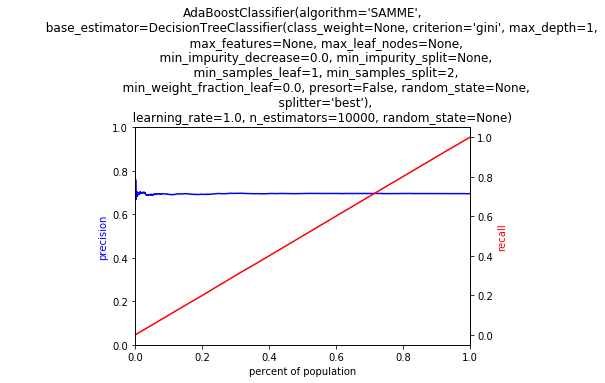

<Figure size 432x288 with 0 Axes>

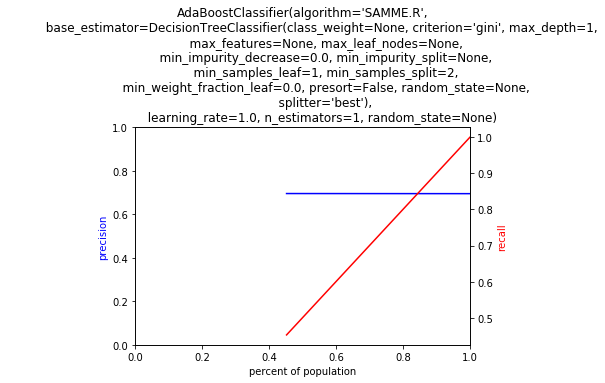

<Figure size 432x288 with 0 Axes>

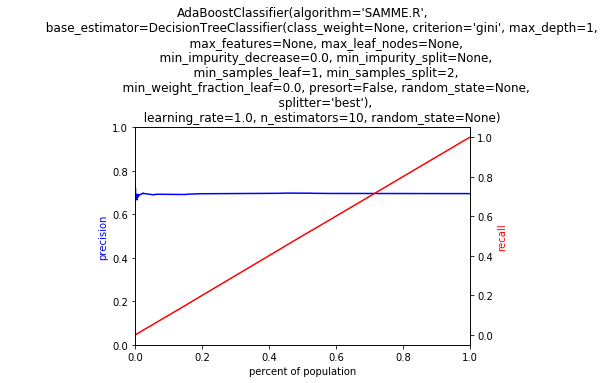

<Figure size 432x288 with 0 Axes>

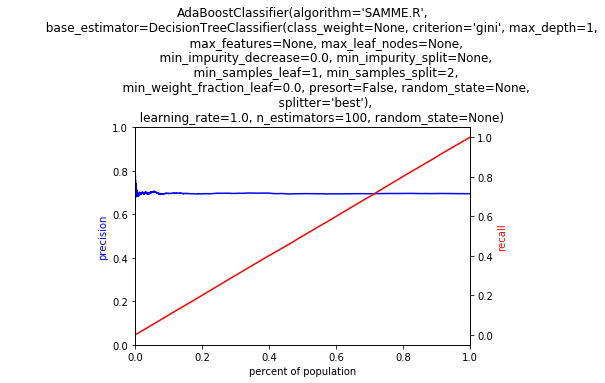

<Figure size 432x288 with 0 Axes>

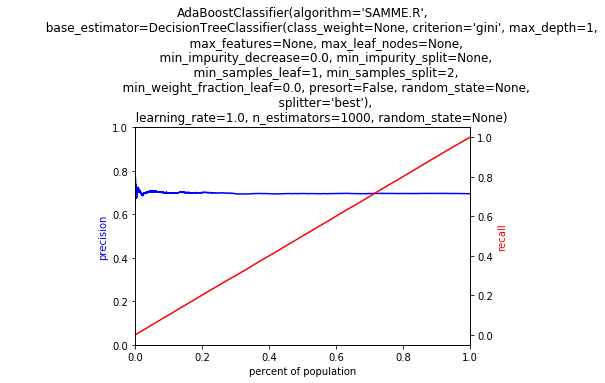

<Figure size 432x288 with 0 Axes>

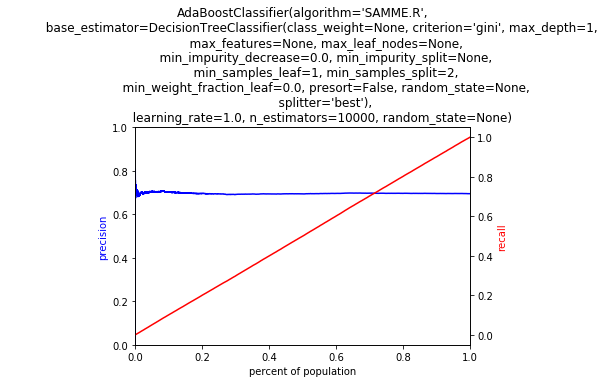

LR


<Figure size 432x288 with 0 Axes>

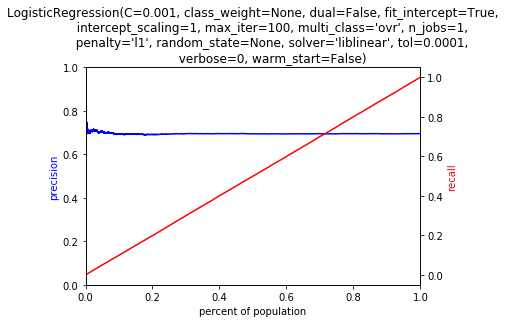

<Figure size 432x288 with 0 Axes>

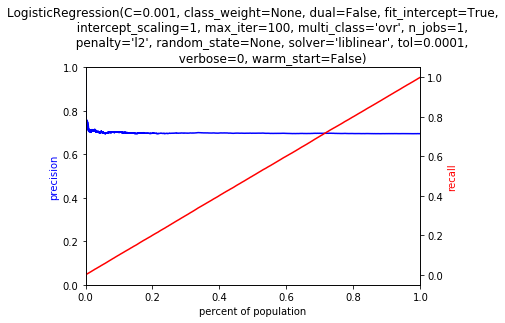

<Figure size 432x288 with 0 Axes>

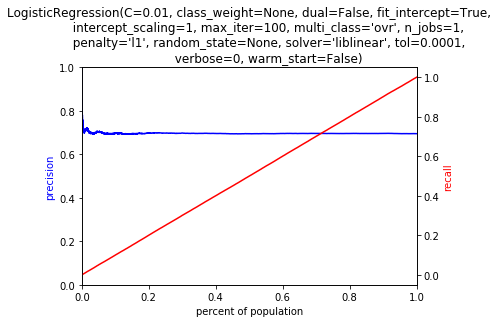

<Figure size 432x288 with 0 Axes>

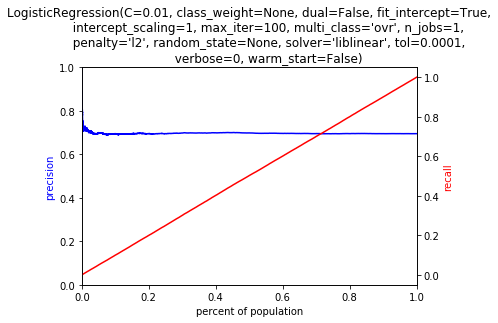

<Figure size 432x288 with 0 Axes>

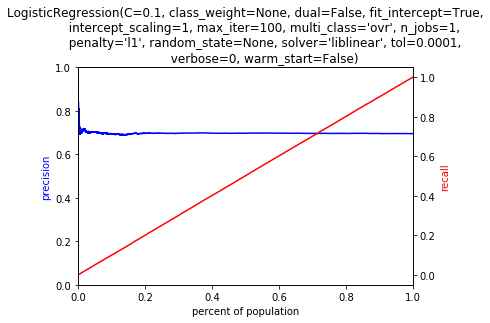

<Figure size 432x288 with 0 Axes>

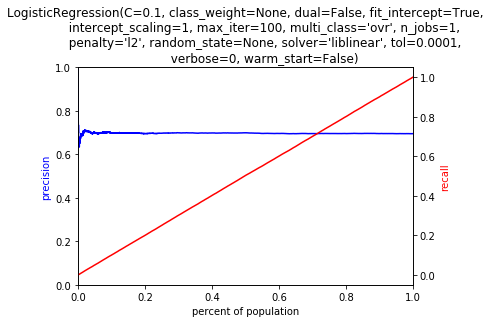

<Figure size 432x288 with 0 Axes>

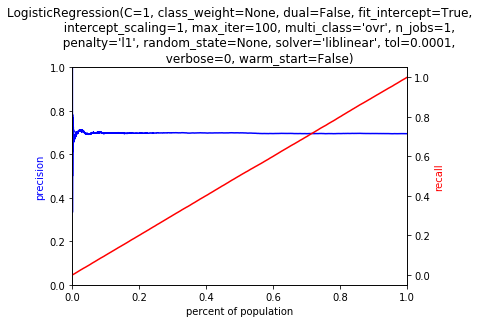

<Figure size 432x288 with 0 Axes>

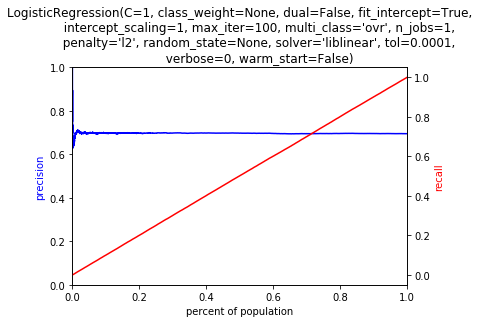

<Figure size 432x288 with 0 Axes>

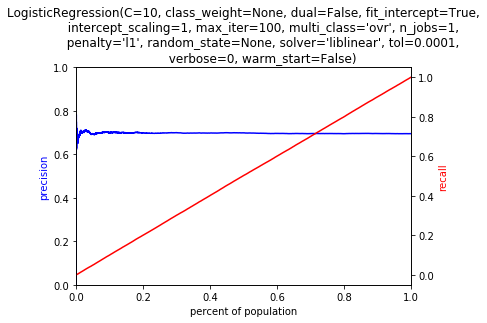

<Figure size 432x288 with 0 Axes>

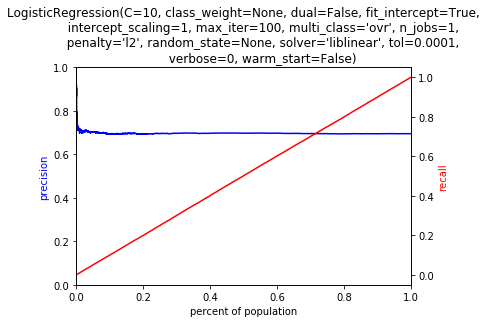

GB


<Figure size 432x288 with 0 Axes>

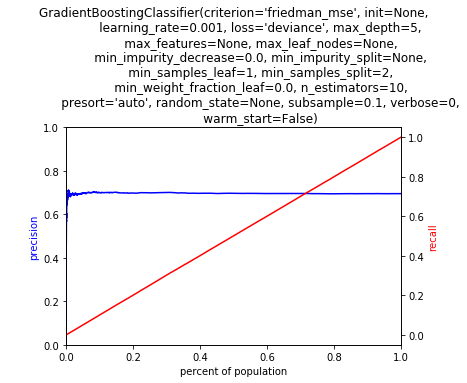

<Figure size 432x288 with 0 Axes>

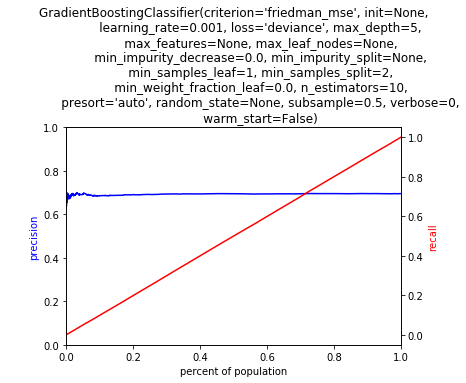

<Figure size 432x288 with 0 Axes>

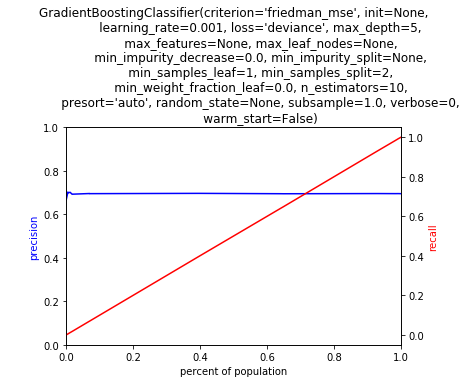

<Figure size 432x288 with 0 Axes>

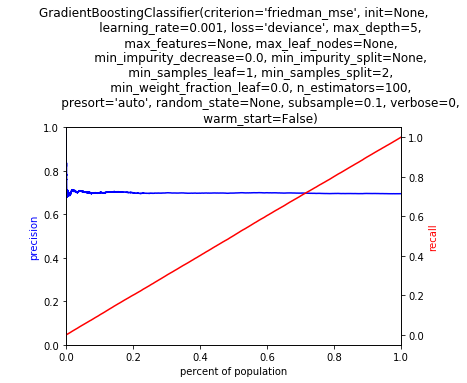

<Figure size 432x288 with 0 Axes>

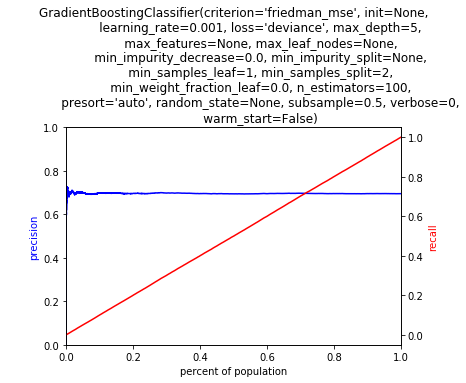

<Figure size 432x288 with 0 Axes>

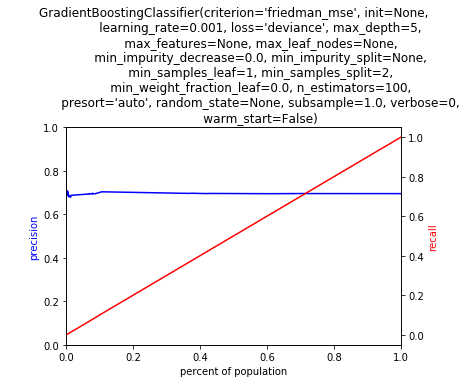

<Figure size 432x288 with 0 Axes>

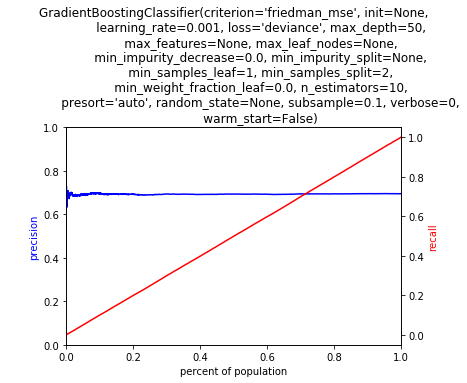

<Figure size 432x288 with 0 Axes>

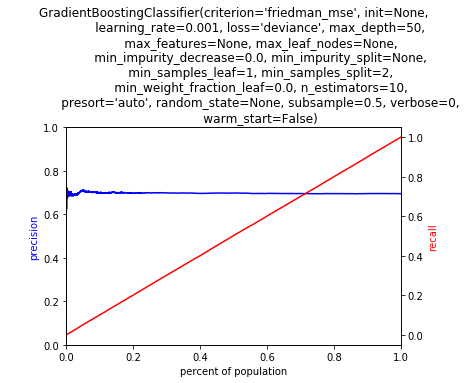

<Figure size 432x288 with 0 Axes>

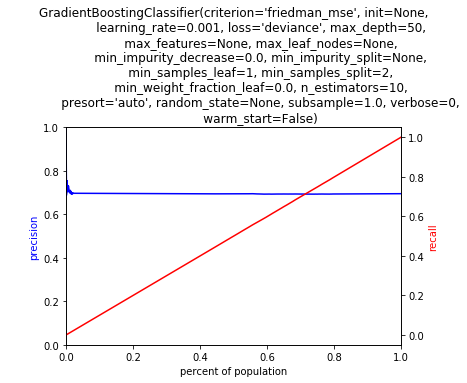

KeyboardInterrupt: 

In [33]:
results = modeling_analysis.master_loop_with_time(full_df, start_time_date, end_time_date, prediction_windows, max_features, predictor, models_to_run, clfs, grid)

In [ ]:
results

## Results